<a href="https://colab.research.google.com/github/gokul-pv/EVA6_Assignmets_Session4/blob/main/EVA6_Session_4_assignment_v5_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the necessary modules**

In [17]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import torchvision

**Defining the Model**

In [18]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),      #Input: 28*28*1    Output: 28 * 28 * 8    
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.069),
            nn.Conv2d(8, 16, 3, padding=1),     #Input: 28*28*8   Output: 28 * 28 * 16   
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.069),
            nn.MaxPool2d(2, 2),                 #Input: 28*28*16   Output: 14 * 14 * 16                        
            nn.Conv2d(16, 8, 1),                #Input: 14*14*16   Output: 14 * 14 * 8  (1x1 convolution done to mix 16 channels and create 8 new channels)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),     #Input: 14*14*8   Output: 14 * 14 * 16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.069),
            nn.Conv2d(16, 32, 3, padding=1),    #Input: 14*14*816  Output: 14 * 14 * 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.069),
            nn.MaxPool2d(2, 2),                 #Input: 14*14*32   Output: 7 * 7 * 32
            nn.Conv2d(32, 16, 1),               #Input: 7*7*32     Output: 7 * 7 * 16 (1x1 convolution done to mix 32 channels and create 16 new channels)
        )
      
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3),               #Input: 7*7*16    Output: 5 * 5 * 16
            nn.ReLU(),
            nn.Conv2d(16, 16, 3)                #Input: 5*5*16    Output: 3 * 3 * 16
        )

        self.avgpool = nn.AvgPool2d(3)          # Global avergaing pooling is done to convert 2D data to 1D data Output: 1 * 1 * 16
        self.fc      = nn.Linear(16,10)         # fully connected layer having 16 inputs and 10 outputs

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        x = self.fc(x.reshape(-1,16))
        x = x.view(-1, 10)
        return F.log_softmax(x)

**Model summary**

In [19]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,168
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
           Conv2d-11           [-1, 16, 14, 14]           1,168
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


**Loading the dataset**



In [20]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9, 1.1)),                          
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [21]:
'''Accessing a batch '''
sample_batch=next(iter(train_loader))
x1,y1=sample_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


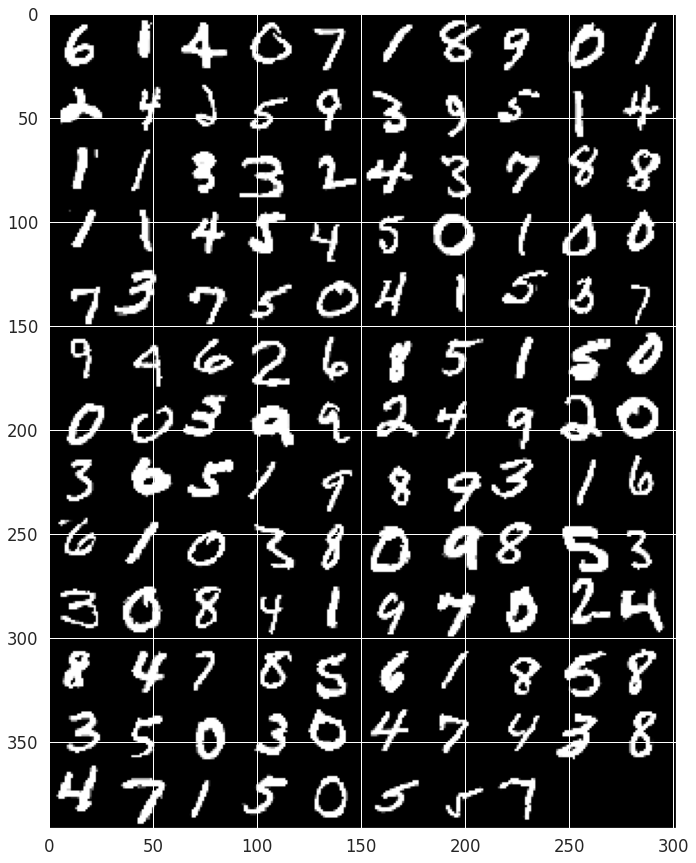

In [22]:
'''Creating a grid of images'''
grid = torchvision.utils.make_grid(x1, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

**Defining Train and Test Functions**

In [23]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()   

        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch = {epoch} loss={loss.item()} batch_id={batch_idx}')

    train_loss /= len(train_loader.dataset)    
    train_losses.append(train_loss)
    train_accuracy.append(100. * correct / len(train_loader.dataset))
      

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

**Selecting the optmizer**

In [24]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

**Training for 19 epoch**

In [25]:
for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0850, Accuracy: 9723/10000 (97.23%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9875/10000 (98.75%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9891/10000 (98.91%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9900/10000 (99.00%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9895/10000 (98.95%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9909/10000 (99.09%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9913/10000 (99.13%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)



epoch = 10 loss=0.053641725331544876 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9924/10000 (99.24%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9907/10000 (99.07%)



epoch = 14 loss=0.015749391168355942 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9928/10000 (99.28%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9915/10000 (99.15%)



epoch = 16 loss=0.005873033776879311 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)



epoch = 19 loss=0.028979307040572166 batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)



**Result**

---


An accurarcy of 99.46 is achieved in 19th epoch with model of 12,674 parameters for the MNIST data

**Ploting the loss**

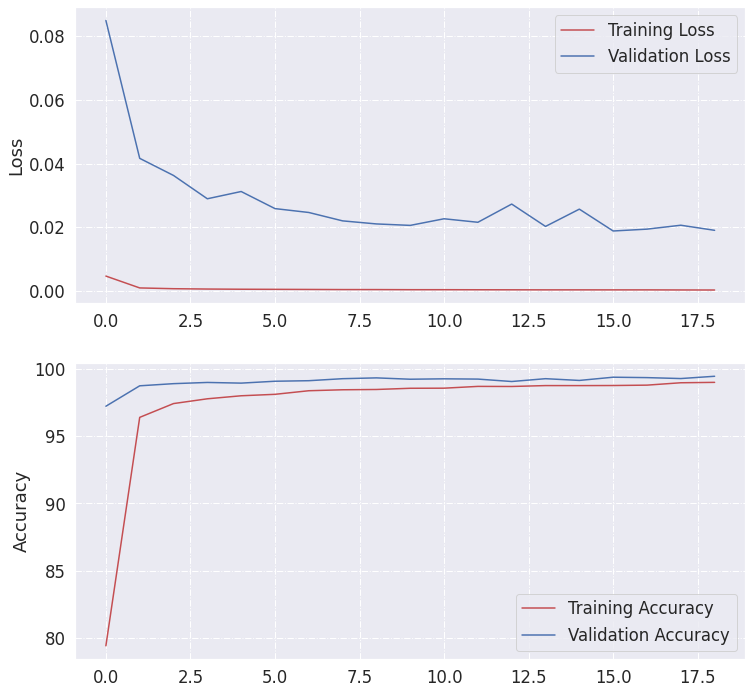

In [26]:
# plot training history
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
plt.ylabel('Loss')
plt.plot(train_losses, 'r', label='Training Loss')
plt.plot(test_losses, 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()


plt.subplot(2,1,2)
ax = plt.gca()
plt.ylabel('Accuracy')
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(test_accuracy, 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()